In [1]:
import os
import numpy as np
data = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project"
images = [im for im in os.listdir(data) if 'jpeg' in im]
# images
exd = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark"
cont = os.listdir(exd)
test = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/1.png"
test1 = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/Project Codes/low-light.jpg"

In [2]:
obj_dct = {}
for obj in cont:
  obj_dct[obj] = [os.path.join(exd, obj, val) for val in os.listdir(os.path.join(exd, obj))]
  print(obj_dct[obj])

['/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark/Boat/2015_01303.jpg', '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark/Boat/2015_00747.jpg', '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark/Boat/2015_00960.jpg', '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark/Boat/2015_00753.jpg', '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark/Boat/2015_00790.jpg', '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark/Boat/2015_00974.jpg', '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project

<ipython-input-9-10c14e344424>:111: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file) / 255.0  # Normalize to [0, 1]


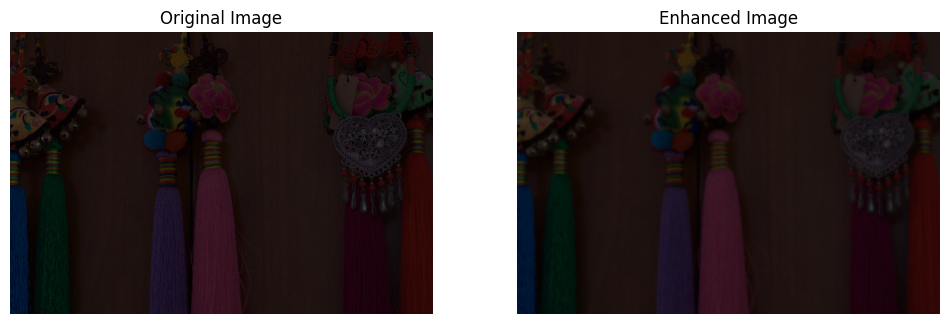

In [ ]:
import numpy as np
from scipy import optimize
from scipy import misc
import imageio
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline


def forward_differences(u):
    '''
        u: Image matrix of dimensions (y,x)
        returns matrix fu of dimensions (2,y,x)
    '''
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,:-1,:] = u[1:,:] - u[:-1,:]	#y differences (rows-1,cols)
    fu[1,:,:-1] = u[:,1:] - u[:,:-1]	#x differences (rows,cols-1)

    return fu

def backward_differences(u):
    '''
        u: Image matrix of dimensions (y,x)
        returns matrix fu of dimensions (2,y,x)
    '''
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,1:,:] = u[1:,:] - u[:-1,:]	#y differences
    fu[1,:,1:] = u[:,1:] - u[:,:-1]	#x differences

    return fu

def forward_differences_second(u):
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,1:-1,:] = u[0:-2,:] - 2*u[1:-1,:] + u[2:,:]	#y differences
    fu[1,:,1:-1] = u[:,0:-2] - 2*u[:,1:-1] + u[:,2:]	#x differences

    return fu

class TotalGradient:
    def __init__(self,img):
        self.shape = img.shape
        self.nchannels = img.shape[2]

        self.gradX = np.zeros( (img.shape[0],img.shape[1],self.nchannels ) )
        self.gradY = np.zeros( (img.shape[0],img.shape[1],self.nchannels ) )

        self.grad2X = np.zeros( (img.shape[0],img.shape[1],self.nchannels ) )
        self.grad2Y = np.zeros( (img.shape[0],img.shape[1],self.nchannels ) )

        for c in range(self.nchannels):
            fd = forward_differences(img[:,:,c])
            self.gradX[:,:,c] += fd[0] #dx
            self.gradY[:,:,c] += fd[1] #dy

            fd2 = forward_differences_second(img[:,:,c])
            self.grad2X[:,:,c] += fd2[0] #dx
            self.grad2Y[:,:,c] += fd2[1] #dy


    def norm(self):
        rows,cols,channels = self.shape

        n=np.zeros( (rows,cols) )
        for c in range(self.nchannels):
            n+=self.gradX[:,:,c]**2 + self.gradY[:,:,c]**2

        return n

class Tikhonov:
    def __init__(self,img,lbda):
        self.fimg = img
        self.lbda = lbda

        self.my_shape=self.fimg.shape
        self.my_size=self.fimg.size

    def fn_jac(self,x):
        _x = x.reshape( self.my_shape )
        TG=TotalGradient(_x)

        S= self.lbda*(TG.grad2X + TG.grad2Y)

        return ( _x - self.fimg -S ).reshape( self.my_size, )

    def tikhonov(self,x):
        _x = x.reshape( self.my_shape )
        TG=TotalGradient(_x)

        v= 0.5*( np.linalg.norm(_x - self.fimg)**2 + self.lbda*np.sum(TG.norm()) )
        return v


def denoise_image(input_image,lbda,max_it,print_output=False):
    if print_output:
        print("Executing Tikhonov...")

    T=Tikhonov(input_image,lbda)
    solution=optimize.minimize(lambda x: T.tikhonov(x),np.zeros(T.fimg.size,),jac=lambda x: T.fn_jac(x),method="CG",options={"maxiter":max_it,"disp":print_output})

    x = solution["x"].reshape( T.my_shape )
    return x



# Load the color image
image_file = test  # Replace with your image file
image = imageio.imread(image_file) / 255.0  # Normalize to [0, 1]


im = denoise_image(image, 1, 200)
# Display the original and final images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Final (processed) image
plt.subplot(1, 2, 2)
plt.imshow(np.clip(im, 0, 1))  # Clip values to valid range [0, 1]
plt.title('Enhanced Image')
plt.axis('off')

plt.show()


## FOURIER TRANSFORM EXPERIMENT

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import gaussian_filter

def separate_illumination_reflectance_rgb(image, cutoff_frequency):
    # Function to apply a low-pass filter and a high-pass filter in the Fourier domain
    def apply_filters(channel):
        # Compute the 2D Fourier transform of the channel
        f_transform = np.fft.fft2(channel)
        f_shift = np.fft.fftshift(f_transform)

        # Create a low-pass filter mask
        rows, cols = channel.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), np.uint8)
        mask[crow-cutoff_frequency:crow+cutoff_frequency, ccol-cutoff_frequency:ccol+cutoff_frequency] = 1

        # Apply the low-pass filter to get the illumination component
        f_shift_illumination = f_shift * mask
        f_ishift_illumination = np.fft.ifftshift(f_shift_illumination)
        illumination = np.fft.ifft2(f_ishift_illumination)
        illumination = np.abs(illumination)

        # Apply a high-pass filter to get the reflectance component
        f_shift_reflectance = f_shift * (1 - mask)
        f_ishift_reflectance = np.fft.ifftshift(f_shift_reflectance)
        reflectance = np.fft.ifft2(f_ishift_reflectance)
        reflectance = np.abs(reflectance)

        return illumination, reflectance

    # Split the image into its RGB components
    r_channel, g_channel, b_channel = cv2.split(image)

    # Apply filters to each channel
    r_illumination, r_reflectance = apply_filters(r_channel)
    g_illumination, g_reflectance = apply_filters(g_channel)
    b_illumination, b_reflectance = apply_filters(b_channel)

    # Merge the channels back to form RGB images
    illumination_rgb = cv2.merge([r_illumination, g_illumination, b_illumination])
    reflectance_rgb = cv2.merge([r_reflectance, g_reflectance, b_reflectance])

    # Normalize the components
    illumination_rgb = cv2.normalize(illumination_rgb, None, 0, 255, cv2.NORM_MINMAX)
    reflectance_rgb = cv2.normalize(reflectance_rgb, None, 0, 255, cv2.NORM_MINMAX)

    return illumination_rgb.astype(np.uint8), reflectance_rgb.astype(np.uint8)


# TV-ADMM denoising (using skimage's denoise_tv_chambolle as a placeholder)
def tv_admm_denoising(reflectance, weight=0.2):
    denoised = np.zeros_like(reflectance)
    for i in range(reflectance.shape[2]):  # Apply denoising channel-wise
        denoised[:, :, i] = denoise_tv_chambolle(reflectance[:, :, i], weight=weight, channel_axis=False)
    return denoised

# Tikhonov regularization for illumination enhancement
def enhance_illumination_tikh(illumination, lambda_reg=1.0, num_iter=100, learning_rate=0.01):
    enhanced_illumination = np.copy(illumination)

    for _ in range(num_iter):
        grad = 2 * (enhanced_illumination - illumination)  # Data fidelity term
        grad += 2 * lambda_reg * gaussian_filter(enhanced_illumination, sigma=2, order=2)  # Regularization term
        enhanced_illumination -= learning_rate * grad

    return enhanced_illumination

def apply_bilateral_filter(image):
    """
    Apply a bilateral filter to the reflectance component to reduce noise
    while preserving edges.
    """
    # Apply a bilateral filter to each channel
    filtered_r = cv2.bilateralFilter( image[:,:,0], 3, 50, 50)
    filtered_g = cv2.bilateralFilter(image[:,:,1], 3, 50, 50)
    filtered_b = cv2.bilateralFilter(image[:,:,2], 3, 50, 50)

    # Merge the filtered channels back to form an RGB image
    filtered_image = cv2.merge([filtered_r, filtered_g, filtered_b])

    return filtered_image


def apply_median_filter(image):
    """
    Apply a median filter to the image component to reduce noise.
    """
    # Apply a median filter to each channel
    median_filtered_r = cv2.medianBlur(image[:,:,0], 3)
    median_filtered_g = cv2.medianBlur(image[:,:,1], 3)
    median_filtered_b = cv2.medianBlur(image[:,:,2], 3)

    # Merge the filtered channels back to form an RGB image
    median_filtered_image = cv2.merge([median_filtered_r, median_filtered_g, median_filtered_b])

    return median_filtered_image

In [ ]:
images = [os.path.join(data, "eval15", "low", x) for x in os.listdir(os.path.join(data, "eval15", "low"))]

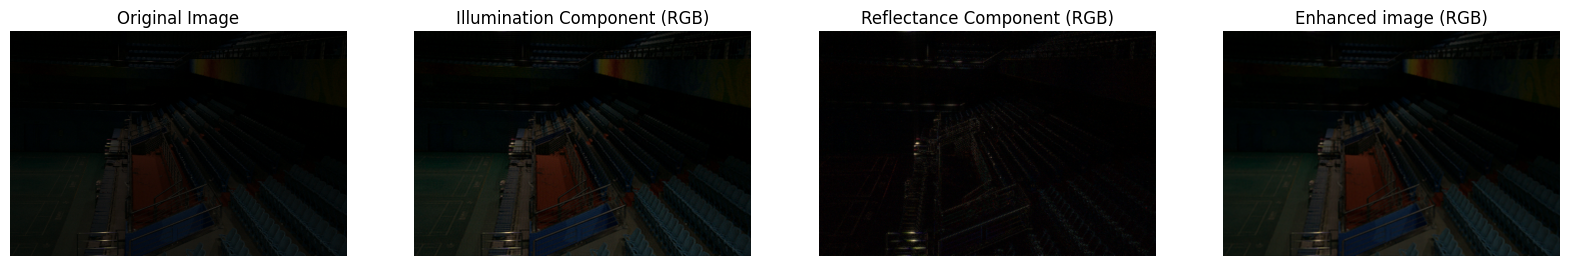

In [ ]:
# Load the image
image_path = images[9]
rgb_image = cv2.imread(image_path)
# Set the cutoff frequency for the low-pass filter
cutoff_frequency = 120  # This value depends on the image size and content

# Separate the illumination and reflectance components
illumination_rgb, reflectance_rgb = separate_illumination_reflectance_rgb(rgb_image, cutoff_frequency)

# Convert the images from BGR to RGB for display purposes
original_rgb = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
illumination_rgb_display = cv2.cvtColor(illumination_rgb, cv2.COLOR_BGR2RGB)
reflectance_rgb_display = cv2.cvtColor(reflectance_rgb, cv2.COLOR_BGR2RGB)

lmda = 0.25

illumination_rgb_display = np.float32(illumination_rgb_display) / 255.0
# # normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
denoised_illumination = enhance_illumination_tikh(illumination_rgb_display.squeeze(), lmda)
# denoised_illumination = denoised_illumination * 255.0
# print(denoised_illumination[0])
denoised_reflectance = tv_admm_denoising(reflectance_rgb_display, weight=0.05)
# denoised_illumination = apply_bilateral_filter_to_reflectance(illumination_rgb_display)
# denoised_reflectance = apply_bilateral_filter(reflectance_rgb_display)
# print(denoised_reflectance[0])

# print(illumination_rgb_display[0])
# print(reflectance_rgb_display[0])
enhanced_image = denoised_illumination + denoised_reflectance
# enhanced_image = apply_bilateral_filter(enhanced_image)
enhanced_image = apply_median_filter(enhanced_image)
# print(enhanced_image[0])
# Display the results
plt.figure(figsize=(20, 16))

plt.subplot(1, 4, 1)
plt.imshow(original_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(illumination_rgb_display)
plt.title('Illumination Component (RGB)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(reflectance_rgb_display)
plt.title('Reflectance Component (RGB)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(enhanced_image)
plt.title('Enhanced image (RGB)')
plt.axis('off')

plt.show()

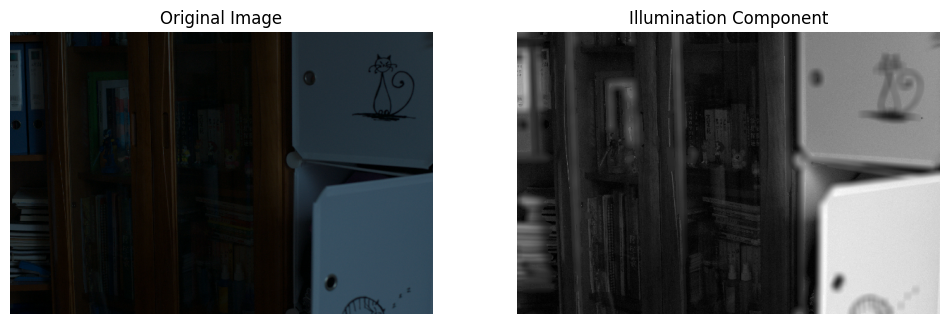

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_neighborhood_variance(image, x, y, neighborhood_size):
    """
    Calculate the variance of pixel values in the neighborhood of (x, y)
    """
    row_start = max(y - neighborhood_size, 0)
    row_end = min(y + neighborhood_size + 1, image.shape[0])
    col_start = max(x - neighborhood_size, 0)
    col_end = min(x + neighborhood_size + 1, image.shape[1])

    neighborhood = image[row_start:row_end, col_start:col_end]
    variance = np.var(neighborhood, axis=(0, 1))
    return variance

def construct_illumination_component(image, neighborhood_size, variance_threshold):
    """
    Construct the illumination component based on neighborhood variance
    """
    height, width, _ = image.shape
    illumination_component = np.zeros((height, width))

    for y in range(height):
        for x in range(width):
            variance = calculate_neighborhood_variance(image, x, y, neighborhood_size)
            if np.all(variance < variance_threshold):
                illumination_component[y, x] = np.mean(image[y, x])
            else:
                # Calculate average value of the neighborhood
                row_start = max(y - neighborhood_size, 0)
                row_end = min(y + neighborhood_size + 1, height)
                col_start = max(x - neighborhood_size, 0)
                col_end = min(x + neighborhood_size + 1, width)
                neighborhood = image[row_start:row_end, col_start:col_end]
                illumination_component[y, x] = np.mean(neighborhood)

    return illumination_component

# Load and preprocess the image
image = cv2.imread(test)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Parameters
neighborhood_size = 5  # Example size, can be adjusted
variance_threshold = 50  # Example threshold, can be adjusted

# Construct the illumination component
illumination = construct_illumination_component(image, neighborhood_size, variance_threshold)

# Normalize the illumination component
illumination_normalized = cv2.normalize(illumination, None, 0, 255, cv2.NORM_MINMAX)

# Display the original image and the illumination component
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(illumination_normalized, cmap='gray')
plt.title('Illumination Component')
plt.axis('off')

plt.show()

